# Coin Toss problem with PyMC3

I tossed my coin $n$ times, and it came up as heads $h$ times. Is it biased?

Given $n$ tosses and $h$ oberserved heads, is it probable that $p$, the probability of getting heads, is close to 0.5?

In [1]:
import warnings
import numpy as np
import pandas as pd

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import scipy.stats as stats

sns.set_style('darkgrid')
%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(42)

Use a [Beta](https://en.wikipedia.org/wiki/Beta_distribution) prior with $\alpha = \beta > 1$ to define our belief that a coin is most likely to be fair ($p = 0.5$), but still leave the possibility for $p$ to be between $0$ and $1$.

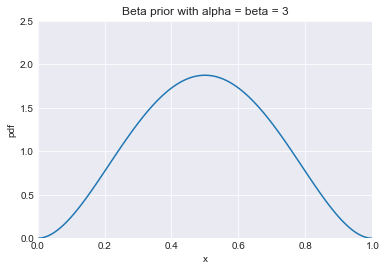

In [2]:
alpha = 3
beta = 3

fig, ax = plt.subplots(1, 1)
prior_beta = stats.beta(alpha, beta)
x = np.linspace(0, 1, 100)
ax.plot(x, prior_beta.pdf(x))
plt.title('Beta prior with alpha = beta = 3')
plt.xlabel('x')
plt.xlim([0, 1])
plt.ylim([0, 2.5])
plt.ylabel('pdf')
plt.show()

Model the flipping of the coin as a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). That runs $n$ tosses of a coin with unknown probability $p$ of getting heads.

In [3]:
n = 100  # Tosses
h = 62  # Number of times head

niter = 2000

with pm.Model() as model: # context management
    # define priors
    p = pm.Beta('p', alpha=alpha, beta=beta, testval=0.5)
    # define likelihood
    y = pm.Binomial('y', n=n, p=p, observed=h)

In [4]:
# Run inference
with model:
    step = pm.Metropolis() # Have a choice of samplers
    trace = pm.sample(niter, step, random_seed=42, progressbar=True)

100%|██████████| 2500/2500 [00:00<00:00, 10950.45it/s]


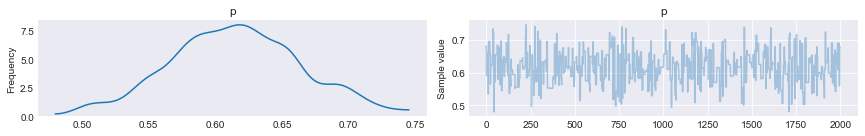

In [5]:
pm.traceplot(trace)
plt.show()

p trace:  (2000,)
p_trace_burnin:  (1500,)


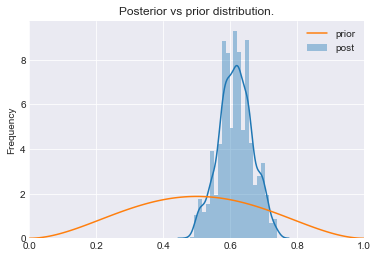

In [6]:
print('p trace: ', trace['p'].shape)
p_trace_burnin = trace['p'][500:]
print('p_trace_burnin: ', p_trace_burnin.shape)

# Compare prior and posterior
sns.distplot(p_trace_burnin, label='post')
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, alpha, beta), label='prior')
plt.legend(loc='best')
plt.title('Posterior vs prior distribution.')
plt.ylabel('Frequency')
plt.xlim([0, 1])
plt.show()

Calculate highest posterior density (HPD) of samples for given alpha. The HPD is the minimum width Bayesian [credible interval](https://en.wikipedia.org/wiki/Credible_interval) (BCI).

alpha is desired probability of [type I error](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors). A type I error (or error of the first kind) is the incorrect rejection of a true null hypothesis. Usually a type I error leads one to conclude that a supposed effect or relationship exists when in fact it doesn't.

In this case there is a $5\%$ error on rejecting $p = 0.5$.

5% HPD: [ 0.50892137  0.70761594]


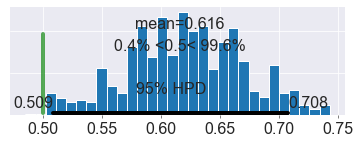

In [7]:
hpd = pm.stats.hpd(p_trace_burnin, alpha=0.05)
print('5% HPD: {}'.format(hpd))

pm.plot_posterior(p_trace_burnin, ref_val=0.5, point_estimate='mean')
plt.show()